In [40]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import evaluate
from datasets import load_metric
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [41]:
def compute_metrics(predicted_masks, true_masks, metric):
    with torch.no_grad():
        metrics = metric.compute(
            predictions=predicted_masks,
            references=true_masks,
            num_labels=2,
            ignore_index=255, #?? What is this? -Keith
            reduce_labels=False, #?? What is this? -Keith
        )
        for key, value in metrics.items():
            if isinstance(value, np.ndarray):
                metrics[key] = value.tolist()
        return metrics  

In [45]:
def evaluate_on_images(images, true_masks, modelCheckpointFilePath="./weights/mobile_sam.pt", model_type="vit_t", device="cpu" ):
    '''
    Parameters:
        -images a list of np arrays, where each entry in the list is the np array representation of an image
        -true_masks a list of boolean np arrays, where the ith entry represents the true mask of the ith entry in images

    Returns:
        -a list of floating point IOU values - the ith entry in the list is the IOU on image i

    '''
    #make the predictions, then call compute_metrics
    sam = sam_model_registry[model_type](checkpoint=modelCheckpointFilePath)
    sam.to(device=device)
    sam.eval()
    predictor = SamPredictor(sam)
    
    metric = evaluate.load("mean_iou")
    iou_vals = [0 for i in range(len(images))]

                
    for image_index in range(len(images)):
        image = images[image_index]
        true_mask = true_masks[image_index]
        true_mask = np.reshape(true_mask, (1, true_mask.shape[0], true_mask.shape[1]))

        
        predictor.set_image(image)
        pred_mask, scores, logits = predictor.predict(
            multimask_output=False,
        )

        metrics = compute_metrics2(true_mask, pred_mask, metric=metric)
        iou_vals[image_index] = metrics["mean_iou"]
        
    return iou_vals



## Just testing my function

In [44]:
NUM_IMGS = 2
SHAPE = (256, 256)
images = [np.zeros((SHAPE[0], SHAPE[1], 3)) for i in range(NUM_IMGS)]
masks = [np.zeros(SHAPE, dtype=bool), np.ones(SHAPE, dtype=bool)]
evaluate_on_images(images, masks)

[0.0, 1.0]

# Now a brief section just testing out the SAM model


In [ ]:
images_folder = "./images"

image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
example_image = cv2.imread(os.path.join(images_folder, image_files[0]))
plt.imshow(example_image)

In [5]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


sam_checkpoint = "./weights/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

#mask_generator = SamAutomaticMaskGenerator(sam)
#masks = mask_generator.generate(example_image)

predictor = SamPredictor(sam)
predictor.set_image(example_image)
masks, scores, logits = predictor.predict(
    multimask_output=False,
)

C:\Users\User\College\Year4\ECE661\661-project\env\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
C:\Users\User\College\Year4\ECE661\661-project\env\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
C:\Users\User\College\Year4\ECE661\661-project\env\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered co

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

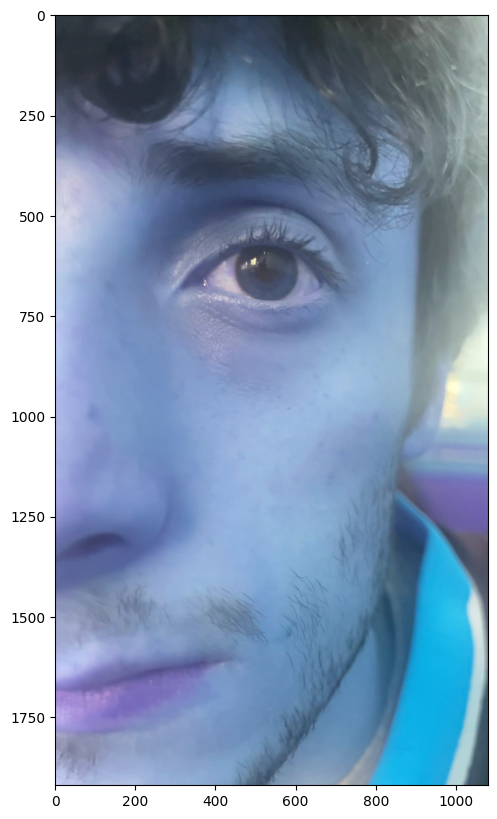

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(example_image)
show_anns([masks])
plt.axis('off')
plt.show() 